In [5]:
%cd "C:\Users\braya\Documents\github\DeSign\ReCU"

C:\Users\braya\Documents\github\DeSign\ReCU


In [6]:
import torch 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
import scipy


import numpy as np
import torch.nn as nn
import scipy.io as sio

from torch.autograd import Function

class BinaryQuantize(Function):
    @staticmethod
    def forward(ctx, input):
        out = torch.sign(input)
        return out

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.clone()
        return grad_input
    
class Threshold3D(nn.Module):

    def __init__(self, filename='./cifar/thresholds/threshold_2x2_v1.mat'):
        super(Threshold3D, self).__init__()


        self.kernel = sio.loadmat(filename)['kernel']
        
        if len(self.kernel.shape) == 2:
            self.kernel = self.kernel[..., None]

        m, n , features = self.kernel.shape
        self.stride = (features, m, n)
        self.stride_conv = (m, n)
        self.kernel = np.transpose( self.kernel, axes=(2, 0, 1) )
        self.kernel = torch.tensor( self.kernel, dtype=torch.float32)[None, ...]
        self.kernel = self.kernel.cuda()
        self.max =  nn.MaxPool3d( self.stride, stride=self.stride)

        self.act = BinaryQuantize()
    
    def forward(self, input):


        temp = input[:, None, ...]
        #ones = torch.sum( input, axis=1, keepdims=True)
        temp = self.max( temp )
        replicates = temp.size(dim=2)
        ones = torch.sum( temp, axis=2, keepdims=False)
        ones = ones*0. + 1

        spatial_thresh = nn.functional.conv_transpose2d(ones, self.kernel, stride=self.stride_conv)
        spatial_thresh = torch.tile(spatial_thresh, (1, replicates, 1, 1))

        output = self.act.apply(input -  spatial_thresh)
        return output

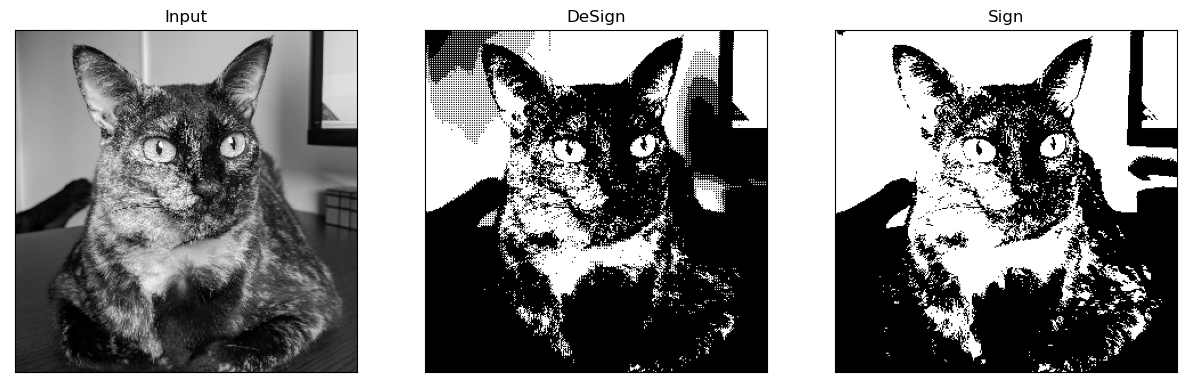

In [8]:
import cv2


size = 300
image = cv2.imread('ciri.jpg', cv2.IMREAD_GRAYSCALE)

# normalize
image = image / 255.0
image = image - np.mean(image)
image = image / np.std(image)

image = cv2.resize(image, (size, size))



DeSign = Threshold3D()


inputs = torch.tensor(image[np.newaxis, np.newaxis, :, :], dtype=torch.float32)
inputs = inputs.to(device)

outputs_design = DeSign(inputs)
outputs_sign   = torch.sign(inputs)

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))


plt.subplot(1, 3, 1)
plt.imshow(inputs[0, 0].cpu(), cmap='gray')
plt.title('Input')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 2)
plt.imshow(outputs_design[0, 0].cpu().detach().numpy(), cmap='gray')
plt.title('DeSign')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 3)
plt.imshow(outputs_sign[0, 0].cpu().detach().numpy(), cmap='gray')
plt.title('Sign')
plt.xticks([])
plt.yticks([])

plt.show()